In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cftime
import calendar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mticker
from matplotlib.colors import TwoSlopeNorm
import imageio
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

In [68]:
ds_ice_59 = xr.open_dataset('/nird/datalake/NS1004K/elihho/slo0059_echam6_BOT_mm_0_1850_var97.nc')
ds_ice_04 = xr.open_dataset('/nird/datalake/NS1004K/elihho/tes0004_echam6_BOT_mm_0_1850_var97.nc')
all_forcing = xr.open_dataset('slo0042+slo0046+slo0050_echam6_BOT_mm_1001_8850_97_NH.nc')
all_forcing = all_forcing.sel(time=slice(70010131.994444, 88501231.994444))

In [69]:
def convert_time(time_array):
    #Converting time to pandas dataframe
    time_df = pd.DataFrame(time_array)#-0.99444445

    #Create empty lists
    time = []
    year = []
    month = []
    date = []
    
    #Split up date format in year, month and day
    for i in range(0,len(time_df[0])):
        time.append(str(time_df[0][i]))
        year.append(int(time[i][0:4])-7001)
        month.append(time[i][4:6])
    
    #Add lists to dataframe
    time_df['year']=year
    time_df['month']=month
    #Get the right format (str, yyyy, mm)
    yyyy=time_df['year'].astype("string").str.zfill(4)
    mm=time_df['month'].astype("string")

    #Combine to datestring in format 'yyyy-mm'
    for i in range(0,len(time_df[0])):
        date_stamp = f'{yyyy[i]}-{mm[i]}'
        date.append(date_stamp)

    #Add date string to dataframe
    time_df['date'] = date
    
    #Convert to datetime object. Works from year 0001!
    def convert_to_datetime(date_str):
        try:
            return datetime.strptime(date_str, '%Y-%m')
        except ValueError as e:
            print(f"Error converting date {date_str}: {e}")
            return pd.NaT
    
    # Apply the conversion function to the 'date' column
    time_df['date'] = time_df['date'].apply(convert_to_datetime)
    return time_df['date']

In [70]:
time_slo = convert_time(ds_ice_59['time'])
time_tes = convert_time(ds_ice_04['time'])
time_all_forcing = convert_time(all_forcing['time'])

Error converting date 0000-01: year 0 is out of range
Error converting date 0000-02: year 0 is out of range
Error converting date 0000-03: year 0 is out of range
Error converting date 0000-04: year 0 is out of range
Error converting date 0000-05: year 0 is out of range
Error converting date 0000-06: year 0 is out of range
Error converting date 0000-07: year 0 is out of range
Error converting date 0000-08: year 0 is out of range
Error converting date 0000-09: year 0 is out of range
Error converting date 0000-10: year 0 is out of range
Error converting date 0000-11: year 0 is out of range
Error converting date 0000-12: year 0 is out of range
Error converting date 0000-01: year 0 is out of range
Error converting date 0000-02: year 0 is out of range
Error converting date 0000-03: year 0 is out of range
Error converting date 0000-04: year 0 is out of range
Error converting date 0000-05: year 0 is out of range
Error converting date 0000-06: year 0 is out of range
Error converting date 0000-0

In [72]:
seaice_tes = ds_ice_04.assign_coords(time = ('time', list(time_tes)))
seaice_slo = ds_ice_59.assign_coords(time = ('time', list(time_slo)))
seaice_all_forcing = all_forcing.assign_coords(time = ('time', list(time_all_forcing)))

In [75]:
seaice_tes_lia = seaice_tes.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
seaice_slo_lia = seaice_slo.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
seaice_all_forcing_lia = seaice_all_forcing.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))

In [76]:
# Extract latitude
lat = seaice_tes_lia['lat']

# Calculate weights: cos(lat) in radians
weights = np.cos(np.deg2rad(lat))

artic_lat = slice(89, 60)

artic_lia_tes = seaice_tes_lia['var97'].sel(lat=artic_lat).weighted(weights).mean(dim=['lat', 'lon'])
artic_lia_slo = seaice_slo_lia['var97'].sel(lat=artic_lat).weighted(weights).mean(dim=['lat', 'lon'])
artic_lia_all_forcing = seaice_all_forcing_lia['var97'].sel(lat=artic_lat).weighted(weights).mean(dim=['lat', 'lon'])

In [77]:
def calculate_monthly_mean(array):
    # Assuming 'time' contains datetime.datetime objects
    years = [t.year for t in array['time'].values]
    months = [t.month for t in array['time'].values]
    # Add these as coordinates to your DataArray
    array['year'] = ('time', years)
    array['month'] = ('time', months)

    monthly_mean_data = array.groupby('month').mean(dim='time')
    return monthly_mean_data

In [78]:
monthly_mean_tes = calculate_monthly_mean(artic_lia_tes)
monthly_mean_slo = calculate_monthly_mean(artic_lia_slo)
monthly_mean_all_forcing = calculate_monthly_mean(artic_lia_all_forcing)

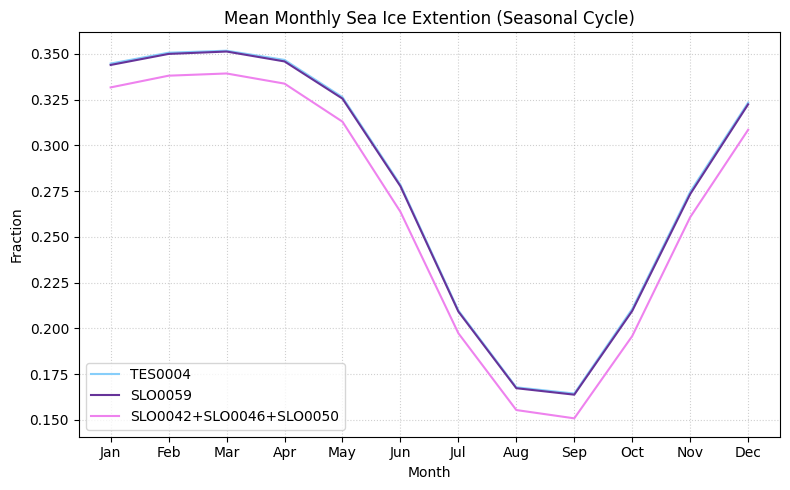

In [79]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


plt.figure(figsize=(8, 5))
plt.plot(months, monthly_mean_tes.values, linestyle='-', color='lightskyblue', label='TES0004')
plt.plot(months, monthly_mean_slo.values, linestyle='-', color='rebeccapurple', label='SLO0059')
plt.plot(months, monthly_mean_all_forcing.values, linestyle='-', color = 'violet', label='SLO0042+SLO0046+SLO0050')

plt.title("Mean Monthly Sea Ice Extention (Seasonal Cycle)")
plt.ylabel("Fraction")
plt.xlabel("Month")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [80]:
rolling_year = 5
rolling_months = rolling_year*12

In [82]:
artic_lia_smoothed_tes = artic_lia_tes.rolling(time=rolling_months, center=True).mean()
artic_lia_smoothed_slo = artic_lia_slo.rolling(time=rolling_months, center=True).mean()
artic_lia_smoothed_all_forcing = artic_lia_all_forcing.rolling(time=rolling_months, center=True).mean()

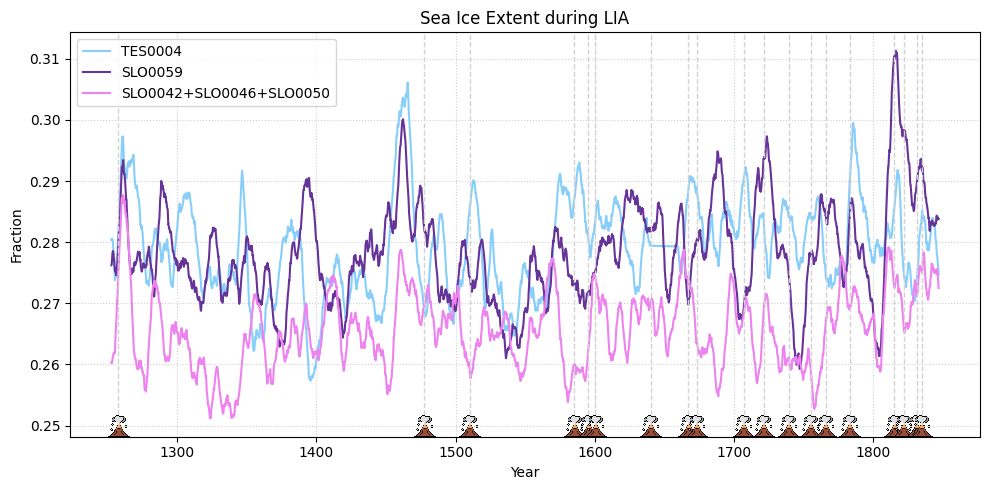

In [83]:
volcano_years = [1257, 1477, 1510, 1585, 1595, 1600, 1640, 1667, 1673, 1707,
                 1721, 1739, 1755, 1766, 1783, 1815, 1822, 1831, 1835]

volcano = [datetime(year, 7, 1) for year in volcano_years]

volcano_img = mpimg.imread("volcano.png")
volcano_icon = OffsetImage(volcano_img, zoom=0.03)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(artic_lia_tes['time'], artic_lia_smoothed_tes, linestyle='-', color='lightskyblue', label='TES0004')
ax.plot(artic_lia_slo['time'], artic_lia_smoothed_slo.values, linestyle='-', color='rebeccapurple', label='SLO0059')
ax.plot(artic_lia_all_forcing['time'], artic_lia_smoothed_all_forcing.values, linestyle='-', color='violet', label='SLO0042+SLO0046+SLO0050')

for vt in volcano:
    ax.axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
    ab = AnnotationBbox(volcano_icon, (vt, ax.get_ylim()[0]), frameon=False, box_alignment=(0.5, 0))
    ax.add_artist(ab)

ax.set_title("Sea Ice Extent during LIA")
ax.set_ylabel("Fraction")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### Maps of extention after eruptions

In [60]:
def superposed_epoch_analysis_maps(data, eruption_years, window_before=5, window_after=15):
    window = np.arange(-window_before, window_after + 1)
    anomalies = []

    for year in eruption_years:
        start = year - window_before
        end = year + window_after

        if (start in data.year.values) and (end in data.year.values):
            window = data.sel(year=slice(start, end))
            baseline = data.sel(year=slice(year - window_before, year - 1)).mean(dim='year')
            anomaly = window - baseline
            anomalies.append(anomaly)

    if not anomalies:
        raise ValueError("No valid events with complete data windows.")

    stacked = xr.concat(anomalies, dim='event')  # shape: (event, year, lat, lon)
    mean_anomaly = stacked.mean(dim='event')     # shape: (year, lat, lon)
    std_anomaly = stacked.std(dim='event')       # shape: (year, lat, lon)

    mean_anomaly['lag'] = window  # label the time window as lag
    mean_anomaly = mean_anomaly.assign_coords(lag=window)
    std_anomaly = std_anomaly.assign_coords(lag=window)

    return window, mean_anomaly, std_anomaly

In [62]:
eruption_years = [1257, 1477, 1510, 1585, 1595, 1640, 1667, 1673, 1707, 1721, 1739, 1755, 1766, 1783, 1815, 1822, 1831]

seaice_sea_tes = superposed_epoch_analysis_maps(seaice_tes_lia, eruption_years)

AttributeError: 'Dataset' object has no attribute 'year'

In [65]:
seaice_tes_lia

<xarray.Dataset> Size: 513MB
Dimensions:  (lon: 192, lat: 96, time: 6959)
Coordinates:
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * time     (time) object 56kB 1250-01-01 1250-02-01 ... 1849-10-01 1849-11-01
Data variables:
    var97    (time, lat, lon) float32 513MB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Sep 08 13:09:19 2020: cdo cat tes0004__echam6_BOT_mm_70...
    institution:  Max-Planck-Institute for Meteorology
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...